# Project Awesome
## Formula One Race Data

API documentation: http://ergast.com/mrd/

Our project is to uncover patterns in race car and race data provided by Formula One data at ergast.com/mrd. The possible relationships we’ll examine include driver performance and attributes and changes in race stats over time. The tables we’re ingesting are finishing statuses, race results, qualifying results, and driver info. Because the datasets’ date ranges differ, we’ll narrow in on a fixed date range so we have good coverage in our analysis.

In [1]:
# Setup.
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

import numpy as np
import itertools 
from datetime import datetime
pd.set_option('display.max_colwidth', -1)
%matplotlib inline  

## Get race results data.

In [2]:
api = 'http://ergast.com/api/f1/2008/5/results.json'
resp = requests.get(api).json()

def get_race_result(season_number, year ):
    api = 'http://ergast.com/api/f1/{}/{}/results.json'.format(year, season_number)
    data = requests.get(api).json()
                                         #resp.get('MRData').get('RaceTable').get('Races')[0].get('Results')
    temp_df =  pd.DataFrame.from_records(data.get('MRData').get('RaceTable').get('Races')[0].get('Results'))
    circuit=data.get('MRData').get('RaceTable').get('Races')[0].get('Circuit')
    temp_df['circuit_name']=circuit.get('circuitName')
    temp_df['seasonNbr'] = season_number
    temp_df['year'] = year
    return temp_df

results = []
seasons = np.arange(2003,2018,1)
rounds = np.arange(1,15,1)
for s in seasons:
    for r in rounds:
        result = get_race_result(r, s)
        results.append(result)

out = pd.concat(results, axis=0)
out['driverId']=out.Driver.map(lambda x: x.get('driverId'))
out['car_make']=out.Constructor.map(lambda x: x.get('name'))
out['driver_nat']=out.Driver.map(lambda x: x.get('nationality'))\

race_df=out[['driverId','year','seasonNbr','position','status','car_make','driver_nat','points','circuit_name']]
race_df['points'] = race_df['points'].astype(float)


C:\Users\jarre\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\jarre\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Get driver data.

In [3]:
a=list(race_df['driverId'])
b=set(a)
names =list(b)

results = []
for x in names:
    api=f'http://ergast.com/api/f1/drivers/{x}.json'
    resp=requests.get(api).json().get('MRData').get('DriverTable').get('Drivers')
    results.append(resp)
    
driver_df = pd.DataFrame.from_records(results)
driver_df['driverId'] = driver_df[0].map(lambda x: x.get('driverId'))
driver_df['givenName'] = driver_df[0].map(lambda x: x.get('givenName'))
driver_df['familyName'] = driver_df[0].map(lambda x: x.get('familyName'))
driver_df['nationality'] = driver_df[0].map(lambda x: x.get('nationality'))
driver_df['dateOfBirth'] = driver_df[0].map(lambda x: x.get('dateOfBirth'))
driver_df.head()

def calc_age(some_brday):
    date_time_bday = datetime.strptime(some_brday, '%Y-%m-%d')
    return round((datetime.today() - date_time_bday).days / 365)


driver_df['years_old'] = driver_df.dateOfBirth.map(calc_age)
driver_df = driver_df[['driverId','givenName','familyName','nationality','dateOfBirth','years_old']]

In [4]:
driver_df.head()

,driverId,givenName,familyName,nationality,dateOfBirth,years_old
0,bourdais,Sébastien,Bourdais,French,1979-02-28,40
1,monteiro,Tiago,Monteiro,Portuguese,1976-07-24,43
2,haryanto,Rio,Haryanto,Indonesian,1993-01-22,26
3,wehrlein,Pascal,Wehrlein,German,1994-10-18,24
4,villeneuve,Jacques,Villeneuve,Canadian,1971-04-09,48


In [5]:
merge_table = pd.merge(race_df, driver_df, on="driverId")
bins = [19, 29, 39, 49, 59]
group_names = ["20s", "30s", "40s", "50s"]
merge_table["age_group"] = pd.cut(merge_table["years_old"], bins, labels=group_names)
merge_table.drop_duplicates(inplace = True)
colors = ['#FF0000', '#800000', '#D2691E', '#B8860B', '#B22222',
         '#FF69B4', '#4B0082', '#FFFACD', '#ADD8E6', '#FF00FF',
         '#7FFFD4', '#FFA500', '#B0E0E6', '#FFD700', '#4682B4',
         '#FFFF00', '#7FFF00', '#A9A9A9', '#9400D3', '#F8F8FF',
         '#9ACD32', '#FFDAB9', '#000000', '#4169E1', '#C0C0C0',
         '#FFE4C4', '#BDB76B', '#228B22', '#F0FFF0', '#CD853F',]

In [6]:
age_points = merge_table.groupby('age_group').agg({'points':['sum'],'driverId':['nunique']})
age_points.columns = ['_'.join(col).strip() for col in age_points.columns.values]
age_points['ave_by_age'] = age_points['points_sum'] / age_points['driverId_nunique']

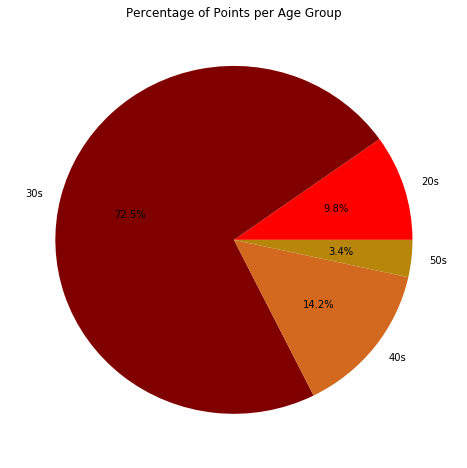

In [7]:
age_points.plot.pie(y='points_sum', colors = colors, figsize=(8, 8),autopct='%1.1f%%')
plt.title("Percentage of Points per Age Group")
plt.legend().remove()
plt.ylabel("")
plt.savefig("../Images/points_per_age_pie.png")

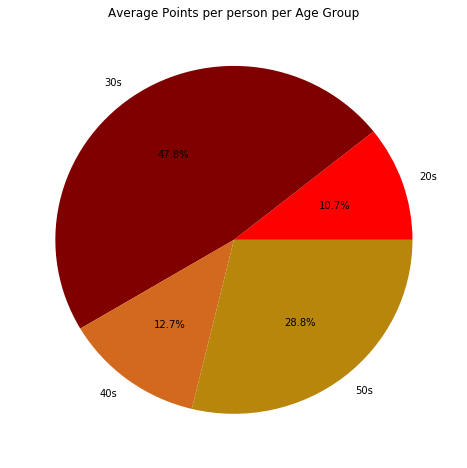

In [8]:
age_points.plot.pie(y='ave_by_age', colors = colors, figsize=(8,8),autopct='%1.1f%%')
plt.title("Average Points per person per Age Group")
plt.legend().remove()
plt.ylabel("")
plt.savefig("../Images/ave_points_per_age_pie.png")

In [9]:
co_age_points = merge_table.groupby(['nationality','years_old']).agg({'years_old':['nunique'],'points':['sum']})
co_age_points.columns = ['_'.join(col).strip() for col in co_age_points.columns.values]
co_age_points.reset_index(inplace = True)
co_age_points['ave_by_age'] = co_age_points['points_sum'] / co_age_points['years_old_nunique']

In [10]:
average_age_df = merge_table.groupby(['nationality','age_group']).agg({'years_old':['nunique'],'points':['sum']})
average_age_df.columns = ['_'.join(col).strip() for col in average_age_df.columns.values]
average_age_df.reset_index(inplace = True)
average_age_df['ave_by_group'] = average_age_df['points_sum'] / average_age_df['years_old_nunique']

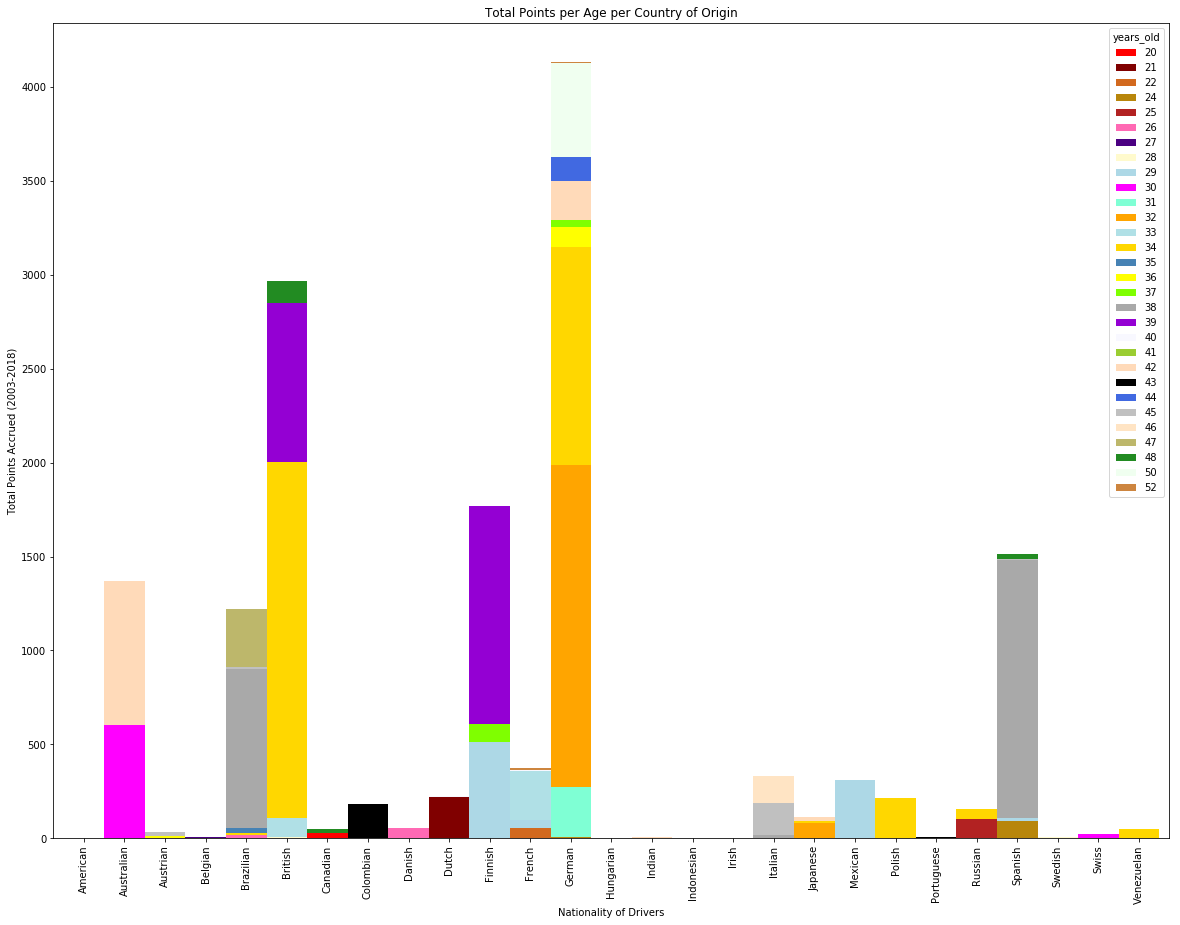

In [11]:
pivot_df = co_age_points.pivot(index='nationality', columns='years_old', values='points_sum')
pivot_df.fillna(0, inplace = True)
pivot_df.plot.bar(stacked=True, color=colors, width = 1, figsize=(20,15))
plt.title("Total Points per Age per Country of Origin")
plt.xlabel("Nationality of Drivers")
plt.ylabel("Total Points Accrued (2003-2018)")
plt.savefig("../Images/points_per_age.png")

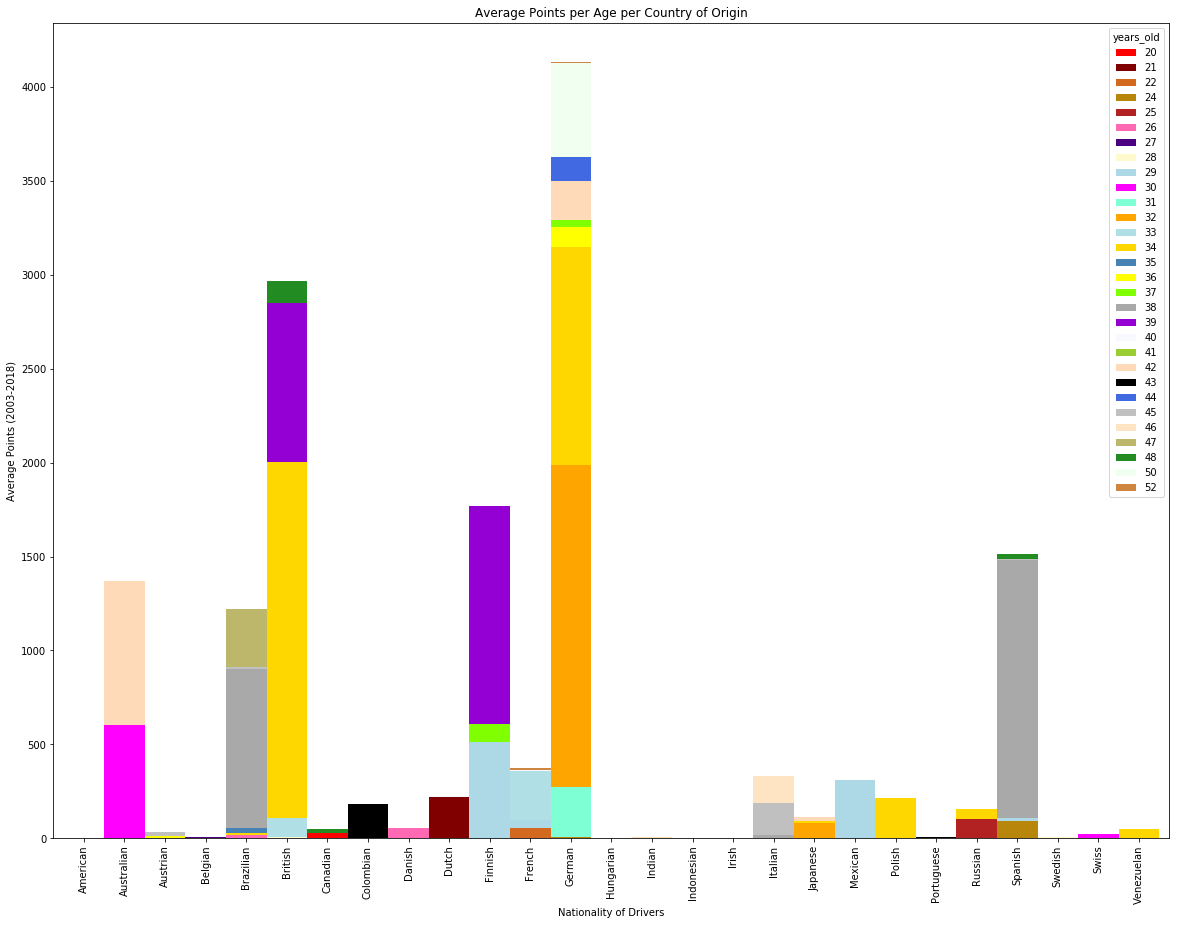

In [12]:
ave_pivot = co_age_points.pivot(index='nationality', columns='years_old', values='ave_by_age')
ave_pivot.fillna(0, inplace = True)
ave_pivot.plot.bar(stacked=True, color=colors, width = 1, figsize=(20,15))
plt.title("Average Points per Age per Country of Origin")
plt.xlabel("Nationality of Drivers")
plt.ylabel("Average Points (2003-2018)")
plt.savefig("../Images/ave_points_per_age.png")

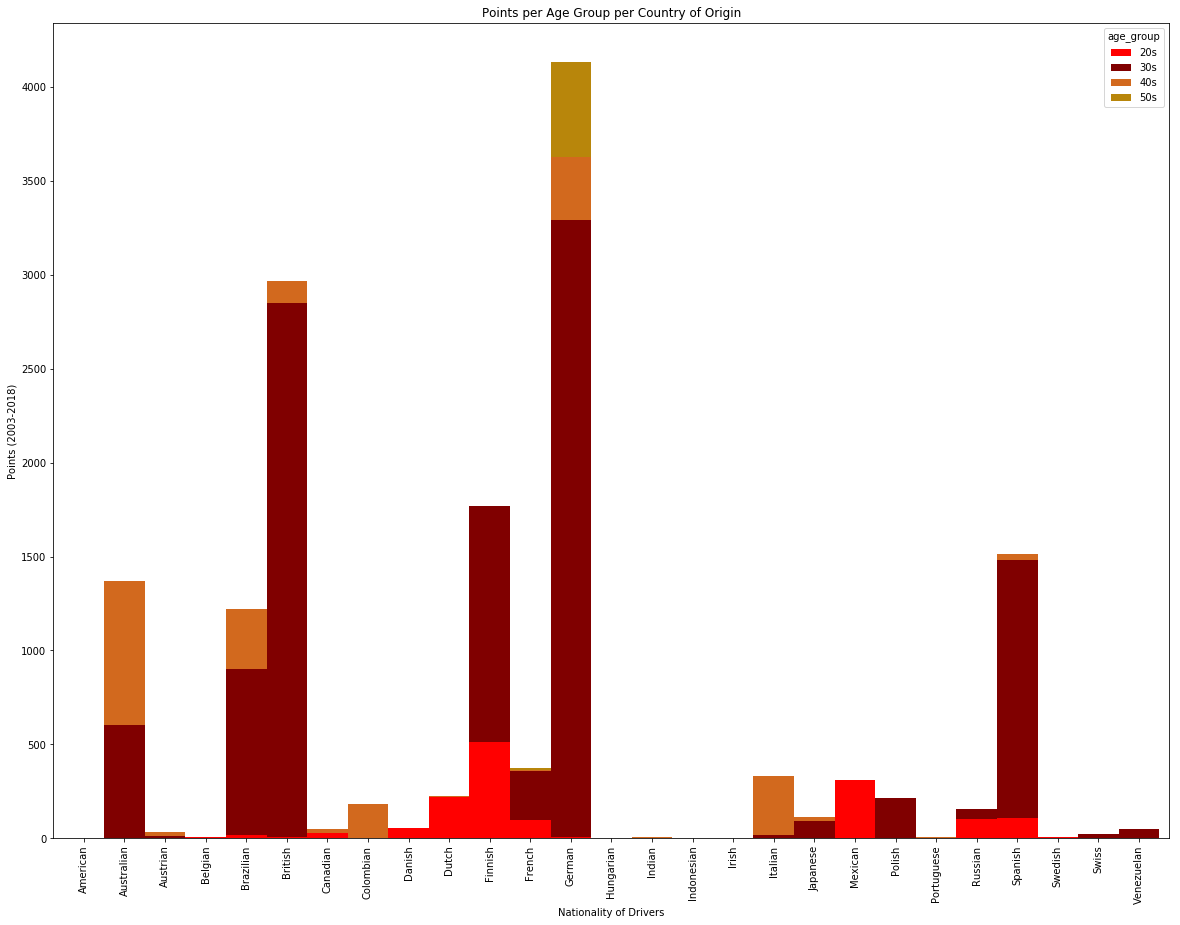

In [13]:
group_pivot = average_age_df.pivot(index='nationality', columns='age_group', values='points_sum')
group_pivot.fillna(0, inplace = True)
group_pivot.plot.bar(stacked=True, color=colors, width = 1, figsize=(20,15))
plt.title("Points per Age Group per Country of Origin")
plt.xlabel("Nationality of Drivers")
plt.ylabel("Points (2003-2018)")
plt.savefig("../Images/points_per_age_group.png")

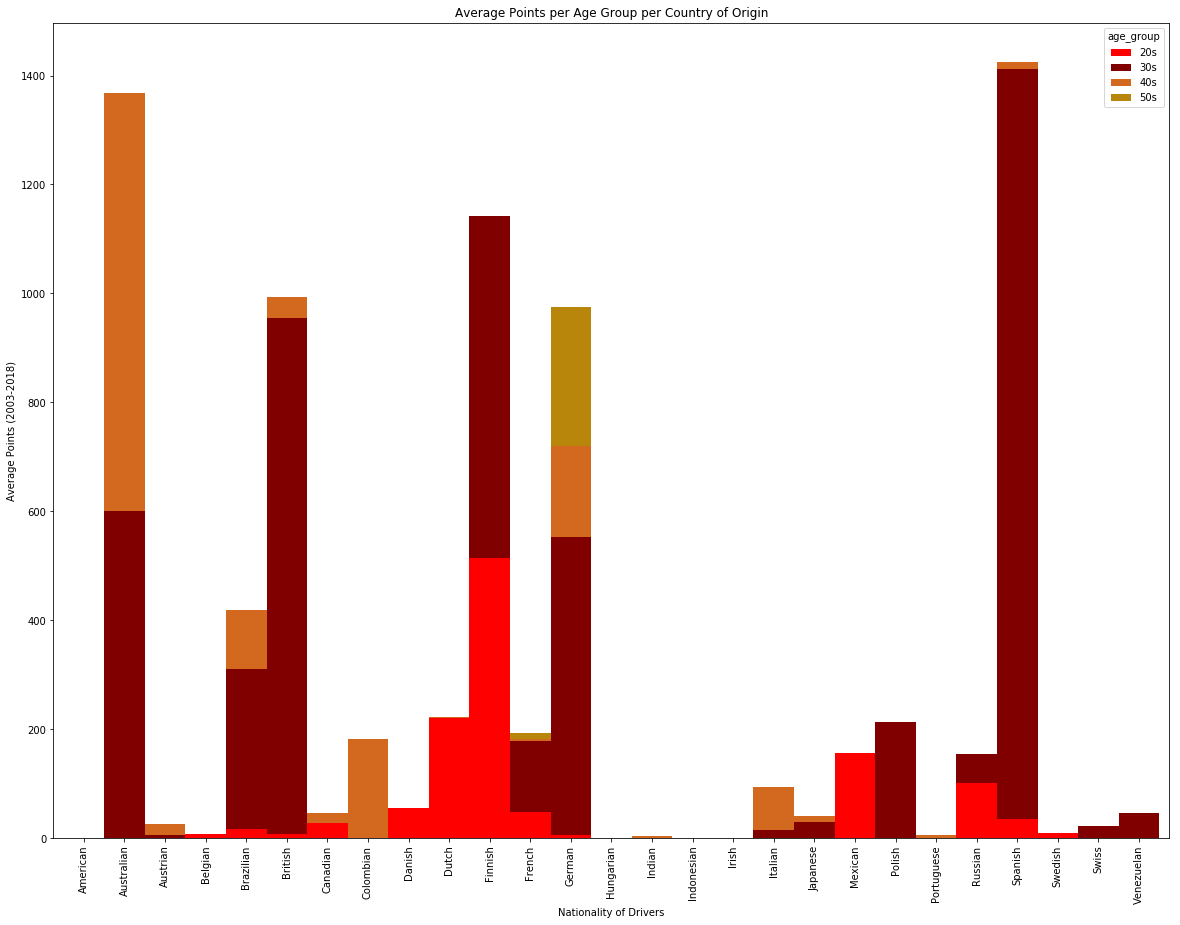

In [14]:
ave_group_pivot = average_age_df.pivot(index='nationality', columns='age_group', values='ave_by_group')
ave_group_pivot.fillna(0, inplace = True)
ave_group_pivot.plot.bar(stacked=True, color=colors, width = 1, figsize=(20,15))
plt.title("Average Points per Age Group per Country of Origin")
plt.xlabel("Nationality of Drivers")
plt.ylabel("Average Points (2003-2018)")
plt.savefig("../Images/ave_points_per_age_group.png")